# Final Project

In [2]:
import os
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql.types import *       # for datatype conversion
from pyspark.sql.functions import *   # for col() function
import pandas as pd

sc = SparkContext.getOrCreate()

import pyspark.sql.types as typ
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
from pyspark.ml.feature import StringIndexer



spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Hotel_Reviews") \
    .config("spark.executor.memory", '2g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'1g') \
    .getOrCreate()

sc = spark.sparkContext
sqlCtx = SQLContext(sc)

In [3]:
path_to_data=os.path.join('data/Hotel_Reviews.csv')
df=spark.read.csv(path_to_data,header=True,inferSchema = True)

In [3]:
df.printSchema()

root
 |-- Hotel_Address: string (nullable = true)
 |-- Additional_Number_of_Scoring: integer (nullable = true)
 |-- Review_Date: string (nullable = true)
 |-- Average_Score: double (nullable = true)
 |-- Hotel_Name: string (nullable = true)
 |-- Reviewer_Nationality: string (nullable = true)
 |-- Negative_Review: string (nullable = true)
 |-- Review_Total_Negative_Word_Counts: integer (nullable = true)
 |-- Total_Number_of_Reviews: integer (nullable = true)
 |-- Positive_Review: string (nullable = true)
 |-- Review_Total_Positive_Word_Counts: integer (nullable = true)
 |-- Total_Number_of_Reviews_Reviewer_Has_Given: integer (nullable = true)
 |-- Reviewer_Score: double (nullable = true)
 |-- Tags: string (nullable = true)
 |-- days_since_review: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lng: string (nullable = true)



In [74]:
df.select("Positive_Review").count()

515738

In [75]:
df.select("Negative_Review").count()

515738

In [55]:
from pyspark.sql.functions import lit,col
reviews_pos=df.select(['Positive_Review']).withColumnRenamed("Positive_Review", "Review")
reviews_neg=df.select(['Negative_Review']).withColumnRenamed("Negative_Review", "Review")
reviews_pos = reviews_pos.withColumn("label",lit(1))
reviews_neg = reviews_neg.withColumn("label",lit(0))
reviews_final = reviews_pos.union(reviews_neg)
reviews_final.dropna()
#reviews_final.reset_index(drop=True,inplace=True)
reviews_final_temp = reviews_final.filter(col("Review") != 'No Positive').filter(col("Review") != 'No Negative')
#my_df.dropna(inplace=True)
#my_df.reset_index(drop=True,inplace=True)

In [56]:
train_set, val_set, test_set = reviews_final_temp.randomSplit([0.80, 0.1, 0.1], seed = 314)


In [58]:
###hashing TF, IDF, then logistic regression

from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="Review", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
#label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashtf, idf])

pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)
train_df.show(100)


+--------------------+-----+--------------------+--------------------+--------------------+
|              Review|label|               words|                  tf|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|                    |    1|                  []|       (65536,[],[])|       (65536,[],[])|
|                    |    1|                  []|       (65536,[],[])|       (65536,[],[])|
|                    |    1|                  []|       (65536,[],[])|       (65536,[],[])|
|                    |    1|                  []|       (65536,[],[])|       (65536,[],[])|
|                    |    1|                  []|       (65536,[],[])|       (65536,[],[])|
|                    |    1|                  []|       (65536,[],[])|       (65536,[],[])|
|                    |    1|                  []|       (65536,[],[])|       (65536,[],[])|
|                    |    1|                  []|       (65536,[],[])|       (65

In [59]:
lr = LogisticRegression(maxIter=100)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)

In [60]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.9748290469503991

In [61]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
accuracy

0.9331365974646335

In [10]:
###CountVectorizer, IDF, and then Logistic Regression
from pyspark.ml.feature import CountVectorizer

tokenizer = Tokenizer(inputCol="Review", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(val_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)

print ("Accuracy Score: ", format(accuracy))
print ("ROC-AUC: ", format(roc_auc))

Accuracy Score:  0.9401638040712468
ROC-AUC:  0.9782662298284932


In [14]:
##### N-gram
###### extract around 16,000 features from unigram, bigram, trigram. 
###### This means around 48,000 features in total were extracted. 
###### Then implementing Chi-Squared feature selection to reduce the number of features to 16,000 in total.

from pyspark.ml.feature import NGram, VectorAssembler
from pyspark.ml.feature import ChiSqSelector

def ngrams_function(inputCol=["Review","target"], n=3):
    tokenizer = [Tokenizer(inputCol="Review", outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=5460,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    lr = [LogisticRegression(maxIter=100)]
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler + label_stringIdx+lr)

In [16]:
trigram_pipelineFit = ngrams_function().fit(train_set)
predictions = trigram_pipelineFit.transform(val_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)
# print accuracy, roc_auc
print ("Accuracy Score: ", format(accuracy))
print ("ROC-AUC: ", format(roc_auc))

Accuracy Score:  0.9522503180661578
ROC-AUC:  0.9859813965327662


In [18]:
###### fit the model on test set

test_predictions = trigram_pipelineFit.transform(test_set)
test_accuracy = test_predictions.filter(test_predictions.label == test_predictions.prediction).count() / float(test_set.count())
test_roc_auc = evaluator.evaluate(test_predictions)
print ("Accuracy Score: ", format(accuracy))
print ("ROC-AUC: ", format(roc_auc))



Accuracy Score:  0.9522503180661578
ROC-AUC:  0.9859813965327662


In [16]:
##### build recommendation engine for hotel ratings ,"Hotel_Name","Reviewer_Score","Review_Date"
recomm_input = df.select(["Reviewer_Nationality","Hotel_Name","Reviewer_Score","Review_Date"])
recomm_input.show(5)

+--------------------+-----------+--------------+-----------+
|Reviewer_Nationality| Hotel_Name|Reviewer_Score|Review_Date|
+--------------------+-----------+--------------+-----------+
|             Russia |Hotel Arena|           2.9|   8/3/2017|
|            Ireland |Hotel Arena|           7.5|   8/3/2017|
|          Australia |Hotel Arena|           7.1|  7/31/2017|
|     United Kingdom |Hotel Arena|           3.8|  7/31/2017|
|        New Zealand |Hotel Arena|           6.7|  7/24/2017|
+--------------------+-----------+--------------+-----------+
only showing top 5 rows



In [17]:
(training, test) = recomm_input.randomSplit([0.8, 0.2])

In [ ]:
##### build recommendation engine for hotel ratings 
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

parts = lines.map(lambda row: row.value.split("::"))
ratingsRDD = parts.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),
                                     rating=float(p[2]), timestamp=long(p[3])))
ratings = spark.createDataFrame(ratingsRDD)
(training, test) = ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

In [4]:
df_tags = df.select(["Tags"])
indexer_tags = StringIndexer(inputCol="Tags", outputCol="Tags_Index")
indexed_tags = indexer_tags.fit(df_tags).transform(df_tags)
indexed_tags.show(10)
#df_tags.collect()

+--------------------+----------+
|                Tags|Tags_Index|
+--------------------+----------+
|[' Leisure trip '...|   19599.0|
|[' Leisure trip '...|    3860.0|
|[' Leisure trip '...|   12270.0|
|[' Leisure trip '...|   18300.0|
|[' Leisure trip '...|     566.0|
|[' Leisure trip '...|   29918.0|
|[' Leisure trip '...|   19836.0|
|[' Leisure trip '...|    2297.0|
|[' Leisure trip '...|    4186.0|
|[' Leisure trip '...|   33867.0|
+--------------------+----------+
only showing top 10 rows



In [20]:
df_hotelname = df.select(["Hotel_Name"])
indexer_hotel = StringIndexer(inputCol="Hotel_Name", outputCol="hotel_Index")
indexed_hotel = indexer_hotel.fit(df_hotelname).transform(df_hotelname)
indexed_hotel.show(10)

+-----------+-----------+
| Hotel_Name|hotel_Index|
+-----------+-----------+
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
+-----------+-----------+
only showing top 10 rows



In [8]:
df_nationality = df.select(["Reviewer_Nationality"])
indexer_nationality = StringIndexer(inputCol="Reviewer_Nationality", outputCol="nationality_Index")
indexed_nationality = indexer_nationality.fit(df_nationality).transform(df_nationality)
indexed_nationality.show(10)

+--------------------+-----------------+
|Reviewer_Nationality|nationality_Index|
+--------------------+-----------------+
|             Russia |             18.0|
|            Ireland |              3.0|
|          Australia |              2.0|
|     United Kingdom |              0.0|
|        New Zealand |             24.0|
|             Poland |             27.0|
|     United Kingdom |              0.0|
|     United Kingdom |              0.0|
|            Belgium |             13.0|
|             Norway |             31.0|
+--------------------+-----------------+
only showing top 10 rows



In [16]:
df_score = df.select(["Reviewer_Score"])
df_score.show(5)

+--------------+
|Reviewer_Score|
+--------------+
|           2.9|
|           7.5|
|           7.1|
|           3.8|
|           6.7|
+--------------+
only showing top 5 rows



In [54]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

df_recomm = df.select("Reviewer_Score","Reviewer_Nationality","Tags","Hotel_Name")

indexer_nationality = StringIndexer(inputCol="Reviewer_Nationality", outputCol="nationality_Index")
indexed_nationality = indexer_nationality.fit(df_recomm).transform(df_recomm)

indexer_hotel = StringIndexer(inputCol="Hotel_Name", outputCol="hotel_Index")
indexed_hotel = indexer_hotel.fit(indexed_nationality).transform(indexed_nationality)

indexer_tags = StringIndexer(inputCol="Tags", outputCol="Tags_Index")
indexed_tags = indexer_tags.fit(indexed_hotel).transform(indexed_hotel)

df_recommendation = indexed_tags.drop("Reviewer_Nationality","Tags","Hotel_Name")

assembler = VectorAssembler(inputCols=["nationality_Index","Tags_Index","Reviewer_Score"],outputCol="features")
df_recommendation_final = assembler.transform(df_recommendation).select("features","hotel_Index")
df_recommendation_final.show(5)

+------------------+-----------+
|          features|hotel_Index|
+------------------+-----------+
|[18.0,19599.0,2.9]|      395.0|
|  [3.0,3860.0,7.5]|      395.0|
| [2.0,12270.0,7.1]|      395.0|
| [0.0,18300.0,3.8]|      395.0|
|  [24.0,566.0,6.7]|      395.0|
+------------------+-----------+
only showing top 5 rows



In [58]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(featuresCol="features",k=6, seed=314)  # 6 clusters here
#model = kmeans.fit(df_recommendation_final.select("features"))
model = kmeans.fit(df_recommendation_final)

In [57]:
transformed_kmeans = model.transform(df_recommendation_final)
transformed_kmeans.show(5)    

+------------------+-----------+----------+
|          features|hotel_Index|prediction|
+------------------+-----------+----------+
|[18.0,19599.0,2.9]|      395.0|         2|
|  [3.0,3860.0,7.5]|      395.0|         3|
| [2.0,12270.0,7.1]|      395.0|         0|
| [0.0,18300.0,3.8]|      395.0|         0|
|  [24.0,566.0,6.7]|      395.0|         1|
+------------------+-----------+----------+
only showing top 5 rows



In [61]:
import numpy as np
cost = np.zeros(50)
for k in range(2,50):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(314) \
            .setFeaturesCol("features")\
            .setPredictionCol("cluster")

    model = kmeans.fit(df_recommendation_final)
    cost[k] = model.computeCost(df_recommendation_final) # requires Spark 2.0 or later

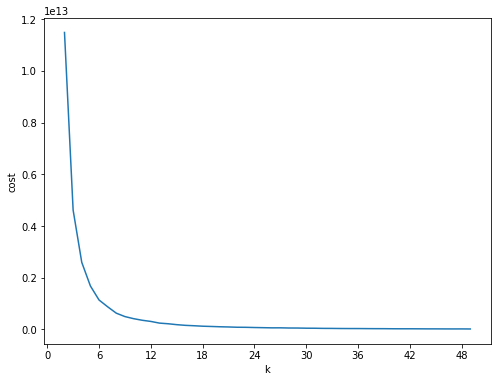

In [63]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,50),cost[2:50])
ax.set_xlabel("k")
ax.set_ylabel("cost")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [66]:
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline

kmeans = KMeans() \
          .setK(6) \
          .setFeaturesCol("features")\
          .setPredictionCol("cluster")

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=3).fit(df_recommendation_final)
# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, kmeans])

model = pipeline.fit(df_recommendation_final)

cluster = model.transform(df_recommendation_final)

In [68]:
cluster.show(10)

+------------------+-----------+------------------+-------+
|          features|hotel_Index|   indexedFeatures|cluster|
+------------------+-----------+------------------+-------+
|[18.0,19599.0,2.9]|      395.0|[18.0,19599.0,2.9]|      0|
|  [3.0,3860.0,7.5]|      395.0|  [3.0,3860.0,7.5]|      4|
| [2.0,12270.0,7.1]|      395.0| [2.0,12270.0,7.1]|      2|
| [0.0,18300.0,3.8]|      395.0| [0.0,18300.0,3.8]|      0|
|  [24.0,566.0,6.7]|      395.0|  [24.0,566.0,6.7]|      1|
|[27.0,29918.0,6.7]|      395.0|[27.0,29918.0,6.7]|      5|
| [0.0,19836.0,4.6]|      395.0| [0.0,19836.0,4.6]|      0|
| [0.0,2297.0,10.0]|      395.0| [0.0,2297.0,10.0]|      1|
| [13.0,4186.0,6.5]|      395.0| [13.0,4186.0,6.5]|      4|
|[31.0,33867.0,7.9]|      395.0|[31.0,33867.0,7.9]|      5|
+------------------+-----------+------------------+-------+
only showing top 10 rows



In [3]:
#find the most top n hotels
import pyspark.sql.functions as F

pop = df.groupBy('Hotel_name')\
  .agg(F.count('Reviewer_Score').alias('Users'),F.round(F.sum('Reviewer_Score'),2).alias('Total_score'))\
  .sort([F.col('Users'),F.col('Total_score')],ascending=[0,0])

pop.show(5)

+--------------------+-----+-----------+
|          Hotel_name|Users|Total_score|
+--------------------+-----+-----------+
|Britannia Interna...| 4789|    32692.8|
| Strand Palace Hotel| 4256|    34596.4|
|Park Plaza Westmi...| 4169|    36073.8|
|Copthorne Tara Ho...| 3578|    28961.2|
|DoubleTree by Hil...| 3212|    27824.8|
+--------------------+-----+-----------+
only showing top 5 rows



In [8]:
#fetch the top 10 hotels
top = 10
Hotel_name_lst = pd.DataFrame(pop.select('Hotel_name').head(top)).astype('str').iloc[:, 0].tolist()
Hotel_name_lst.insert(0,'Tags_Index')
Hotel_name_lst

['Tags_Index',
 'Britannia International Hotel Canary Wharf',
 'Strand Palace Hotel',
 'Park Plaza Westminster Bridge London',
 'Copthorne Tara Hotel London Kensington',
 'DoubleTree by Hilton Hotel London Tower of London',
 'Grand Royale London Hyde Park',
 'Holiday Inn London Kensington',
 'Hilton London Metropole',
 'Millennium Gloucester Hotel London',
 'Intercontinental London The O2']

In [13]:
df_als = df.select("Hotel_name","Reviewer_Score","Tags")
indexer_tags = StringIndexer(inputCol="Tags", outputCol="Tags_Index")
df_adjust = indexer_tags.fit(df_als).transform(df_als).drop("Tags")
df_adjust.show(5)


+-----------+--------------+----------+
| Hotel_name|Reviewer_Score|Tags_Index|
+-----------+--------------+----------+
|Hotel Arena|           2.9|   19599.0|
|Hotel Arena|           7.5|    3860.0|
|Hotel Arena|           7.1|   12270.0|
|Hotel Arena|           3.8|   18300.0|
|Hotel Arena|           6.7|     566.0|
+-----------+--------------+----------+
only showing top 5 rows



In [17]:
#create portfolio table for each tags index
pivot_tab = df_adjust.groupBy('Tags_Index').pivot('Hotel_name').sum('Reviewer_Score')
#pivot_tab.show(5)
#.pivot('Hotel_name').sum('Reviewer_Score')
pivot_tab = pivot_tab.fillna(0)

In [45]:
#fetch the most n portfolio table for each tags index
selected_tab  = pivot_tab.select(Hotel_name_lst)
selected_tab.show(5)

+----------+------------------------------------------+-------------------+------------------------------------+--------------------------------------+-------------------------------------------------+-----------------------------+-----------------------------+-----------------------+----------------------------------+------------------------------+
|Tags_Index|Britannia International Hotel Canary Wharf|Strand Palace Hotel|Park Plaza Westminster Bridge London|Copthorne Tara Hotel London Kensington|DoubleTree by Hilton Hotel London Tower of London|Grand Royale London Hyde Park|Holiday Inn London Kensington|Hilton London Metropole|Millennium Gloucester Hotel London|Intercontinental London The O2|
+----------+------------------------------------------+-------------------+------------------------------------+--------------------------------------+-------------------------------------------------+-----------------------------+-----------------------------+-----------------------+-----------

In [50]:
#header = selected_tab.rdd.first()
#selected_header = selected_tab.rdd.filter(lambda x: x != header)
num = len(selected_tab.columns)
temp = selected_tab.rdd.map(lambda x: list(flatten([x[0],[x[i]/float(sum(x[1:]))
                                                       if sum(x[1:])>0 else x[i]
                                                       for i in range(1,num)]])))
#temp.take(10)
rateings = spark.createDataFrame(temp,selected_tab.columns)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 124.0 failed 1 times, most recent failure: Lost task 0.0 in stage 124.0 (TID 3003, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-50-bf833a03eaef>", line 6, in <lambda>
  File "<ipython-input-50-bf833a03eaef>", line 6, in <listcomp>
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/sql/functions.py", line 44, in _
    jc = getattr(sc._jvm.functions, name)(col._jc if isinstance(col, Column) else col)
AttributeError: 'NoneType' object has no attribute '_jvm'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-50-bf833a03eaef>", line 6, in <lambda>
  File "<ipython-input-50-bf833a03eaef>", line 6, in <listcomp>
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/sql/functions.py", line 44, in _
    jc = getattr(sc._jvm.functions, name)(col._jc if isinstance(col, Column) else col)
AttributeError: 'NoneType' object has no attribute '_jvm'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [7]:
rdd = sc.parallelize([(1,2,3),(3,4,5),(3,6,7)])
rdd.collect()

[(1, 2, 3), (3, 4, 5), (3, 6, 7)]

In [9]:

temp = rdd.map(lambda x: list(flatten([x[0],[x[1]/float(sum(x[1:]))
                                             #      if sum(x[1:])>0 else x[i]
                                               #        for i in range(1,num)]])))
temp.collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 3.0 failed 1 times, most recent failure: Lost task 0.0 in stage 3.0 (TID 5, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-9-f2abada3170d>", line 3, in <lambda>
NameError: name 'num' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:945)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-9-f2abada3170d>", line 3, in <lambda>
NameError: name 'num' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:945)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [29]:
#build the rating matrix
def elemwiseDiv(df_in):
    num = len(df_in.columns)
    temp = df_in.rdd.map(lambda x: list(flatten([x[0],[x[i]/float(sum(x[1:]))
                                                       if sum(x[1:])>0 else x[i]
                                                       for i in range(1,num)]])))
    return spark.createDataFrame(temp,df_in.columns)

ratings = elemwiseDiv(selected_tab)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 57.0 failed 1 times, most recent failure: Lost task 0.0 in stage 57.0 (TID 2258, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-29-a480d00bb0fa>", line 6, in <lambda>
  File "<ipython-input-29-a480d00bb0fa>", line 6, in <listcomp>
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/sql/functions.py", line 44, in _
    jc = getattr(sc._jvm.functions, name)(col._jc if isinstance(col, Column) else col)
AttributeError: 'NoneType' object has no attribute '_jvm'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-29-a480d00bb0fa>", line 6, in <lambda>
  File "<ipython-input-29-a480d00bb0fa>", line 6, in <listcomp>
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/sql/functions.py", line 44, in _
    jc = getattr(sc._jvm.functions, name)(col._jc if isinstance(col, Column) else col)
AttributeError: 'NoneType' object has no attribute '_jvm'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
ratings.show(5)

In [ ]:
#convert rating matrix to long table

from pyspark.sql.functions import array, col, explode, struct, lit

def to_long(df, by):
        """
        reference: https://stackoverflow.com/questions/37864222/transpose-column-to-row-with-spark
        """

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes if c not in by))
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns have to be of the same type"

    # Create and explode an array of (column_name, column_value) structs
    kvs = explode(array([
      struct(lit(c).alias("Hotel_name"), col(c).alias("rating")) for c in cols
    ])).alias("kvs")

In [ ]:
df_all = to_long(ratings,['Tags_Index'])
df_all.show(5)

In [ ]:
#convert the hotel name to numerical index

from pyspark.ml.feature import StringIndexer
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='Hotel_name',
                             outputCol='Hotel_index').fit(df_all)
df_all = labelIndexer.transform(df_all)

df_all.show(5, True)


In [ ]:
train, test = df_all.randomSplit([0.8,0.2])

In [ ]:
import itertools
from math import sqrt
from operator import add
import sys
from pyspark.ml.recommendation import ALS

from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
def computeRmse(model, data):
    """
    Compute RMSE (Root mean Squared Error).
    """
    predictions = model.transform(data)
    rmse = evaluator.evaluate(predictions)
    print("Root-mean-square error = " + str(rmse))
    return rmse

#train models and evaluate them on the validation set

ranks = [4,5]
lambdas = [0.05]
numIters = [30]
bestModel = None
bestValidationRmse = float("inf")
bestRank = 0
bestLambda = -1.0
bestNumIter = -1

val = test.na.drop()
for rank, lmbda, numIter in itertools.product(ranks, lambdas, numIters):
    als = ALS(rank=rank, maxIter=numIter, regParam=lmbda, numUserBlocks=10, numItemBlocks=10, implicitPrefs=False,
              alpha=1.0,
              userCol="CustomerID", itemCol="indexedCusip", seed=1, ratingCol="rating", nonnegative=True)
    model=als.fit(train)

    validationRmse = computeRmse(model, val)
    print("RMSE (validation) = %f for the model trained with " % validationRmse + \
            "rank = %d, lambda = %.1f, and numIter = %d." % (rank, lmbda, numIter))
    if (validationRmse, bestValidationRmse):
        bestModel = model
        bestValidationRmse = validationRmse
        bestRank = rank
        bestLambda = lmbda
        bestNumIter = numIter

model = bestModel

In [ ]:
#make prediction

topredict=test[test['rating']==0]

predictions=model.transform(topredict)
predictions.filter(predictions.prediction>0)\
           .sort([F.col('CustomerID'),F.col('Cusip')],ascending=[0,0]).show(5)